In [9]:
import sys
sys.path.append("..") # relative path to module toolkit

In [10]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# setup
batch_size = 3
steps_per_epoch = int(12525/batch_size) + 1
validation_steps = int(3454/batch_size) + 1

In [12]:
### Model building ####

base_model = ResNet50(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet')

#add a new dense layer to the end of the network inplace of the old layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# add the outplut layer
predictions = Dense(44, activation='softmax')(x)

# create new model composed of pre-trained network and new final layers
model = Model(input=base_model.input, output=predictions)

# we only train on the fully connected layers (the last two layers)
for layer in model.layers[:-2]:
    layer.trainable = False

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
# compile model
model.compile(loss='categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])


In [15]:
train_dir = "../../images/images_genus/train/"
val_dir = "../../images/images_genus/val/"

In [16]:
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

In [17]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False)

Found 12525 images belonging to 44 classes.
Found 3454 images belonging to 44 classes.


In [20]:
#Train
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

Epoch 1/5
4176/4176 [==============================] - 213s 51ms/step - loss: 0.7008 - acc: 0.7683 - val_loss: 5.8942 - val_acc: 0.0594
Epoch 2/5
4176/4176 [==============================] - 210s 50ms/step - loss: 0.6270 - acc: 0.7934 - val_loss: 6.6672 - val_acc: 0.0594
Epoch 3/5
4176/4176 [==============================] - 212s 51ms/step - loss: 0.5547 - acc: 0.8137 - val_loss: 7.2472 - val_acc: 0.0594
Epoch 4/5
4176/4176 [==============================] - 209s 50ms/step - loss: 0.5155 - acc: 0.8253 - val_loss: 7.7908 - val_acc: 0.0594
Epoch 5/5
4176/4176 [==============================] - 210s 50ms/step - loss: 0.4920 - acc: 0.8326 - val_loss: 7.5531 - val_acc: 0.0594


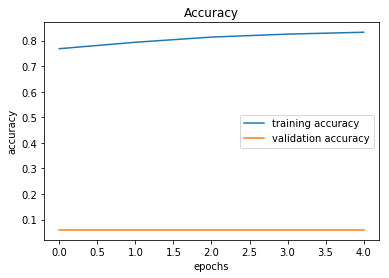

In [23]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [22]:
#save
model.save("restnet50frozen.h5")